In [1]:
# import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss
import seaborn as sns

import torch
import torch_geometric
from torch_geometric.loader import DataLoader

# set figure parameters
sc.settings.set_figure_params(dpi=100)

In [2]:
from celcomen.models.celcomen import celcomen
from celcomen.models.simcomen import simcomen

## define helper functions

In [3]:
# define a function to normalize the g2g
def normalize_g2g(g2g):
    """
    Addresses any small fluctuations in symmetrical weights
    """
    # symmetrize the values
    g2g = (g2g + g2g.T) / 2
    # force them to be between 0-1
    g2g[g2g < 0] = 0
    g2g[g2g > 1] = 1
    # force the central line to be 1
    for idx in range(len(g2g)):
        g2g[idx, idx] = 1
    return g2g

## read in xenium

In [4]:
# read in xenium
avis = sc.read_10x_h5('data/xenium_human_gbm/cell_feature_matrix.h5')
avis.var_names = avis.var_names.astype(str)
avis.var_names_make_unique()
# remove cells with no counts
sc.pp.filter_cells(avis, min_counts=100)
# normalize the data
sc.pp.normalize_total(avis, target_sum=1e6)
sc.pp.log1p(avis)

In [5]:
# read in the spatial
df = pd.read_csv('data/xenium_human_gbm/cells.csv.gz', index_col=0)
df = df.loc[avis.obs.index]

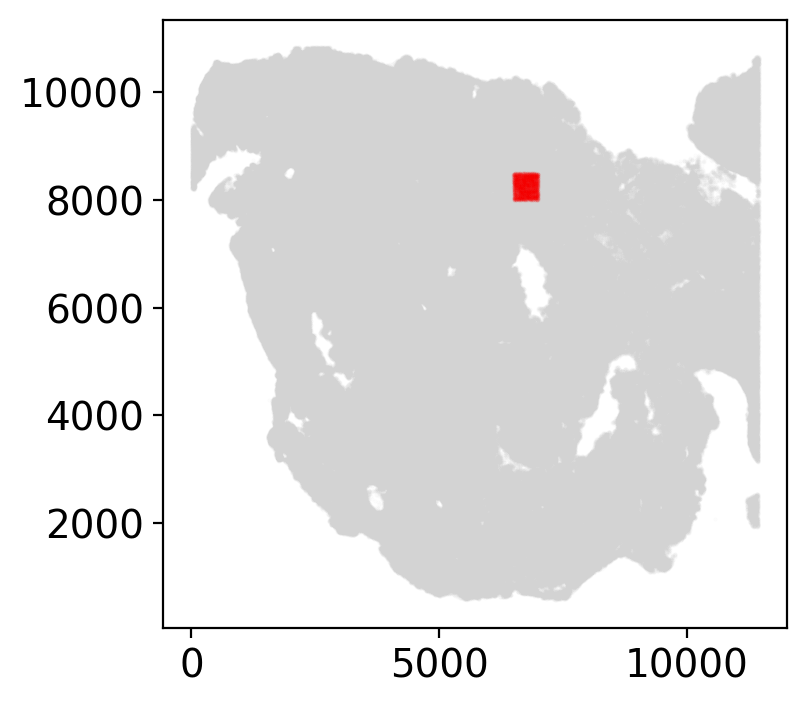

In [6]:
# view the tissue and choose a specific area to focus on
fig, ax = plt.subplots()
ax.grid(False)
ax.scatter(df['x_centroid'], df['y_centroid'], s=0.1, alpha=0.1, color='lightgray')
mask = (df['x_centroid'] < 7000) & (df['x_centroid'] > 6500)
mask = mask & (df['y_centroid'] < 8500) & (df['y_centroid'] > 8000)
ax.scatter(df.loc[mask, 'x_centroid'], df.loc[mask, 'y_centroid'], s=0.1, alpha=0.1, color='r')

In [7]:
# add spatial and subset
avis.obsm['spatial'] = df.loc[avis.obs.index, ['x_centroid','y_centroid']].values
avis = avis[mask].copy()

/nfs/team205/sm58/packages/celcomen_trials/pyg_env/celcomen_tutorial_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
/nfs/team205/sm58/packages/celcomen_trials/pyg_env/celcomen_tutorial_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


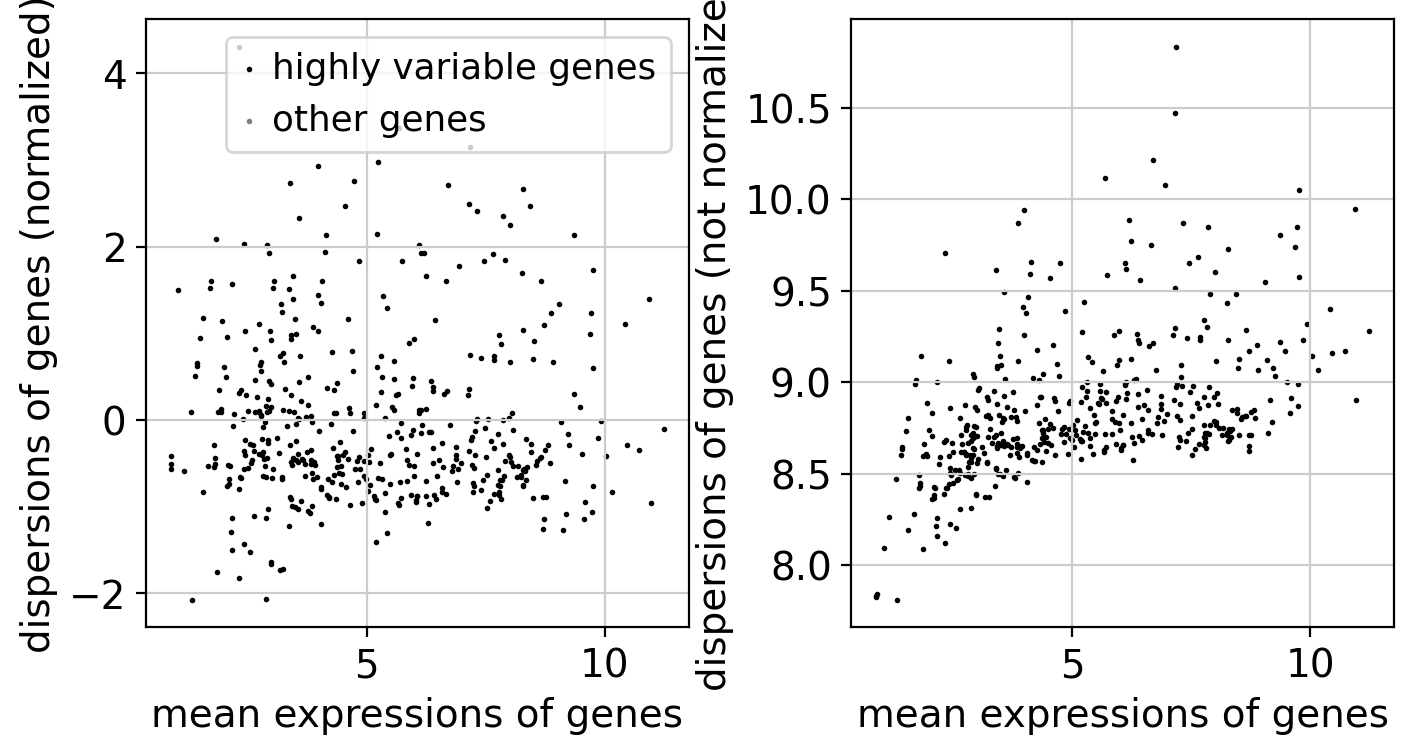

there are 480 hvgs


In [8]:
# compute PCA for the spatial dataset using HVGs
avis.uns['log1p']['base'] = np.e
sc.pp.highly_variable_genes(avis, flavor='seurat', min_mean=0.5, max_mean=7.5, min_disp=0.5, n_top_genes=avis.shape[1])
sc.pl.highly_variable_genes(avis)
# report how many HVGs we're going to use
print('there are', avis.var['highly_variable'].sum(), 'hvgs')

In [9]:
genes = avis.var_names[avis.var['highly_variable']].tolist()

avis2 = sc.read_10x_h5('data/xenium_human_gbm/cell_feature_matrix.h5')
avis2.var_names = avis.var_names.astype(str)
avis2.var_names_make_unique()
# remove cells with no counts
sc.pp.filter_cells(avis2, min_counts=100)
# insert spatial coordinates
avis2.obsm['spatial'] = df.loc[avis2.obs.index, ['x_centroid','y_centroid']].values

avis3 = avis2[mask, genes].copy()
# put a sample id
sc.pp.filter_genes(avis3, min_cells=5)
avis3.obs["sangerID"] = "sample1"

avis3.write_h5ad(
    'data/xenium_human_gbm/avis_for_data_loading.h5',
)

## learn with CCE for xenium

In [10]:
import torch
torch.cuda.is_available()

True

In [11]:
from scipy.spatial.distance import pdist, squareform

distances = squareform(pdist(df.loc[mask, ['x_centroid','y_centroid']]))
# compute the edges as two cell widths apart so 30µm
edge_index = torch.from_numpy(np.array(np.where((distances < 15)&(distances != 0))))

In [12]:
from celcomen.training_plan.train import train
from celcomen.datareaders.datareader import get_dataset_loaders

In [13]:
genes = avis3.var.index

In [14]:
h5ad_path='data/xenium_human_gbm/avis_for_data_loading.h5'

loader = get_dataset_loaders(h5ad_path, "sangerID", 6, True, )

Step 1
=====
Number of graphs in the current batch: 1
DataBatch(x=[1781, 412], edge_index=[2, 10686], y=[1], pos=[1781, 2], batch=[1781], ptr=[2])



In [15]:
n_genes= len(genes) #33
n_neighbors=6
seed=1
zmft_scalar = 0.1
epochs = 300
learning_rate = 5e-3


model = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
model.to("cuda")
losses = train(epochs, learning_rate, model, loader, zmft_scalar=zmft_scalar, seed=1, device="cuda")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 54.11it/s]


[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'loss')]

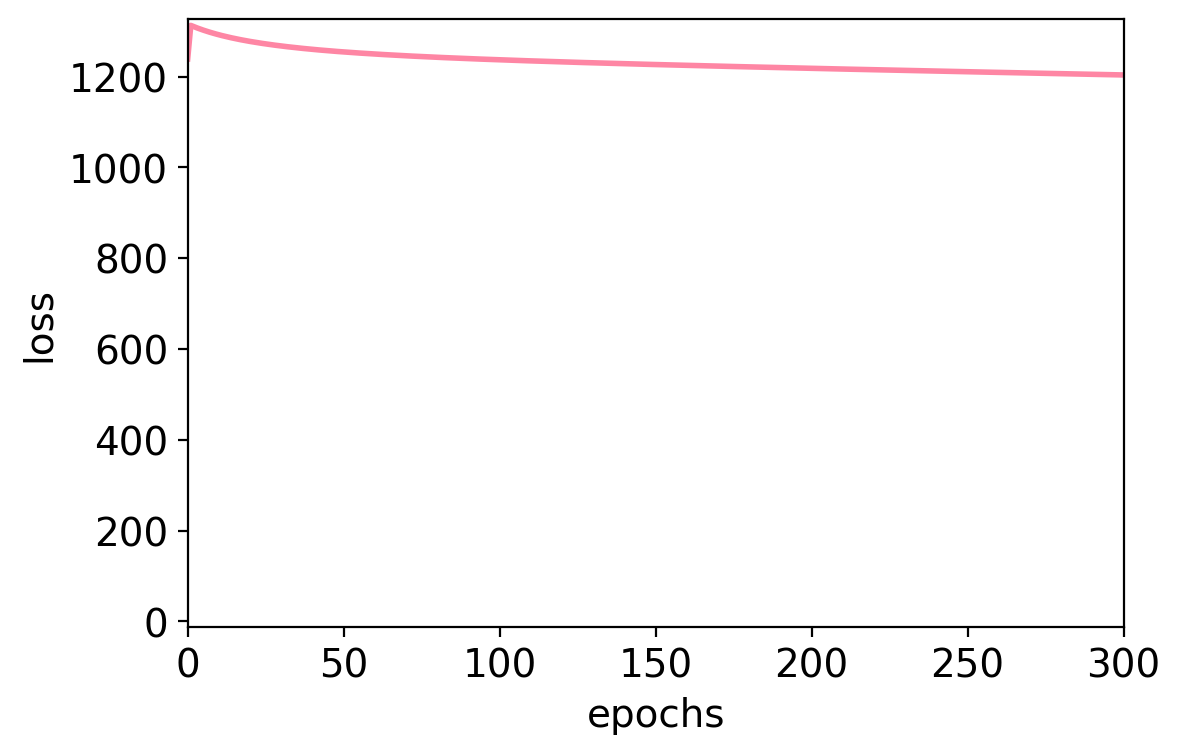

In [16]:
# create the plot
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')

## perform disentanglement

In [17]:
# retrieve the g2gs
g2g_intercellular = pd.DataFrame(model.conv1.lin.weight.detach().cpu().numpy(), index=genes, columns=genes)
g2g_intracellular = pd.DataFrame(model.lin.weight.detach().cpu().numpy(), index=genes, columns=genes)

In [18]:
# define the gene
secs = pd.read_table('data/quickgo_secreted.tsv')['SYMBOL'].unique()
sps = pd.read_table('data/quickgo_surfaceprotein.tsv')['SYMBOL'].unique()
nons = pd.Index(genes)[(~pd.Index(genes).isin(secs))&(~pd.Index(genes).isin(sps))]
secs = pd.Index(genes).intersection(secs)
sps = pd.Index(genes).intersection(sps)

/tmp/ipykernel_3454793/755115305.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x=xs[::-1], y=ys[::-1], saturation=1, ci=95, errwidth=2, capsize=0.3, linewidth=2,
/tmp/ipykernel_3454793/755115305.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xs[::-1], y=ys[::-1], saturation=1, ci=95, errwidth=2, capsize=0.3, linewidth=2,
/tmp/ipykernel_3454793/755115305.py:13: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x=xs[::-1], y=ys[::-1], saturation=1, ci=95, errwidth=2, capsize=0.3, linewidth=2,
/tmp/ipykernel_3454793/755115305.py:13: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.b

0.7916493459738212
6.602549668308228e-05
0.00011133531698984277


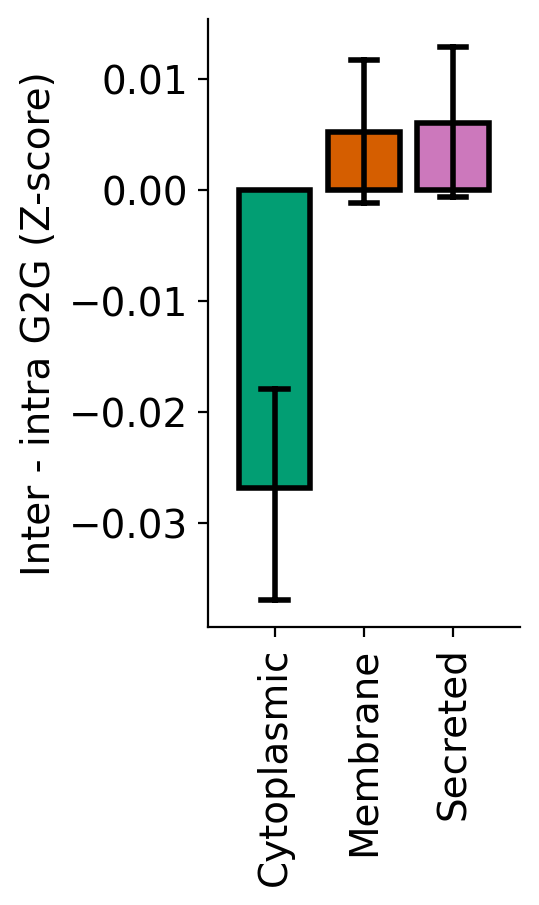

In [19]:
# derive the values
diffs_secs = (g2g_intercellular.loc[secs, :] - g2g_intracellular.loc[secs, :]).values.flatten()
diffs_sps = (g2g_intercellular.loc[sps, :] - g2g_intracellular.loc[sps, :]).values.flatten()
diffs_nons = (g2g_intercellular.loc[nons, :] - g2g_intracellular.loc[nons, :]).values.flatten()
# assemble them
ys = np.hstack([diffs_secs, diffs_sps, diffs_nons])
ys -= ys.mean()
ys /= ys.std()
xs = np.array(['Secreted']*len(diffs_secs)+['Membrane']*len(diffs_sps)+['Cytoplasmic']*len(diffs_nons))
# create plot
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x=xs[::-1], y=ys[::-1], saturation=1, ci=95, errwidth=2, capsize=0.3, linewidth=2,
            errcolor='k', edgecolor='k', palette=['#cc78bc','#d55e00','#029e73'][::-1])
ax.set_xlim(-0.75, 2.75)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('Inter - intra G2G (Z-score)')
ax.spines[['right', 'top']].set_visible(False)
# derive pvalues
p1 = ss.mannwhitneyu(ys[xs == 'Secreted'], ys[xs == 'Membrane'])[1]
p2 = ss.mannwhitneyu(ys[xs == 'Secreted'], ys[xs == 'Cytoplasmic'])[1]
p3 = ss.mannwhitneyu(ys[xs == 'Cytoplasmic'], ys[xs == 'Membrane'])[1]
print(p1, p2, p3, sep='\n')

## perturb the GBM data

In [20]:
# define a function to derive the gex from the sphex
def calc_sphex(gex):
    """
    Calculates the spherical expression matrix from the normal
    """
    # setup the gex
    n_sgenes = gex.shape[1]-1
    sphex = torch.from_numpy(np.zeros((gex.shape[0], n_sgenes)).astype('float32'))
    # compute the gex
    for idx in range(n_sgenes):
        sphex[:,idx] = gex[:,idx]
        for idx_ in range(idx):
            sphex[:,idx] /= torch.sin(sphex[:,idx_])
        sphex[:,idx] = torch.arccos(sphex[:,idx])
    return sphex

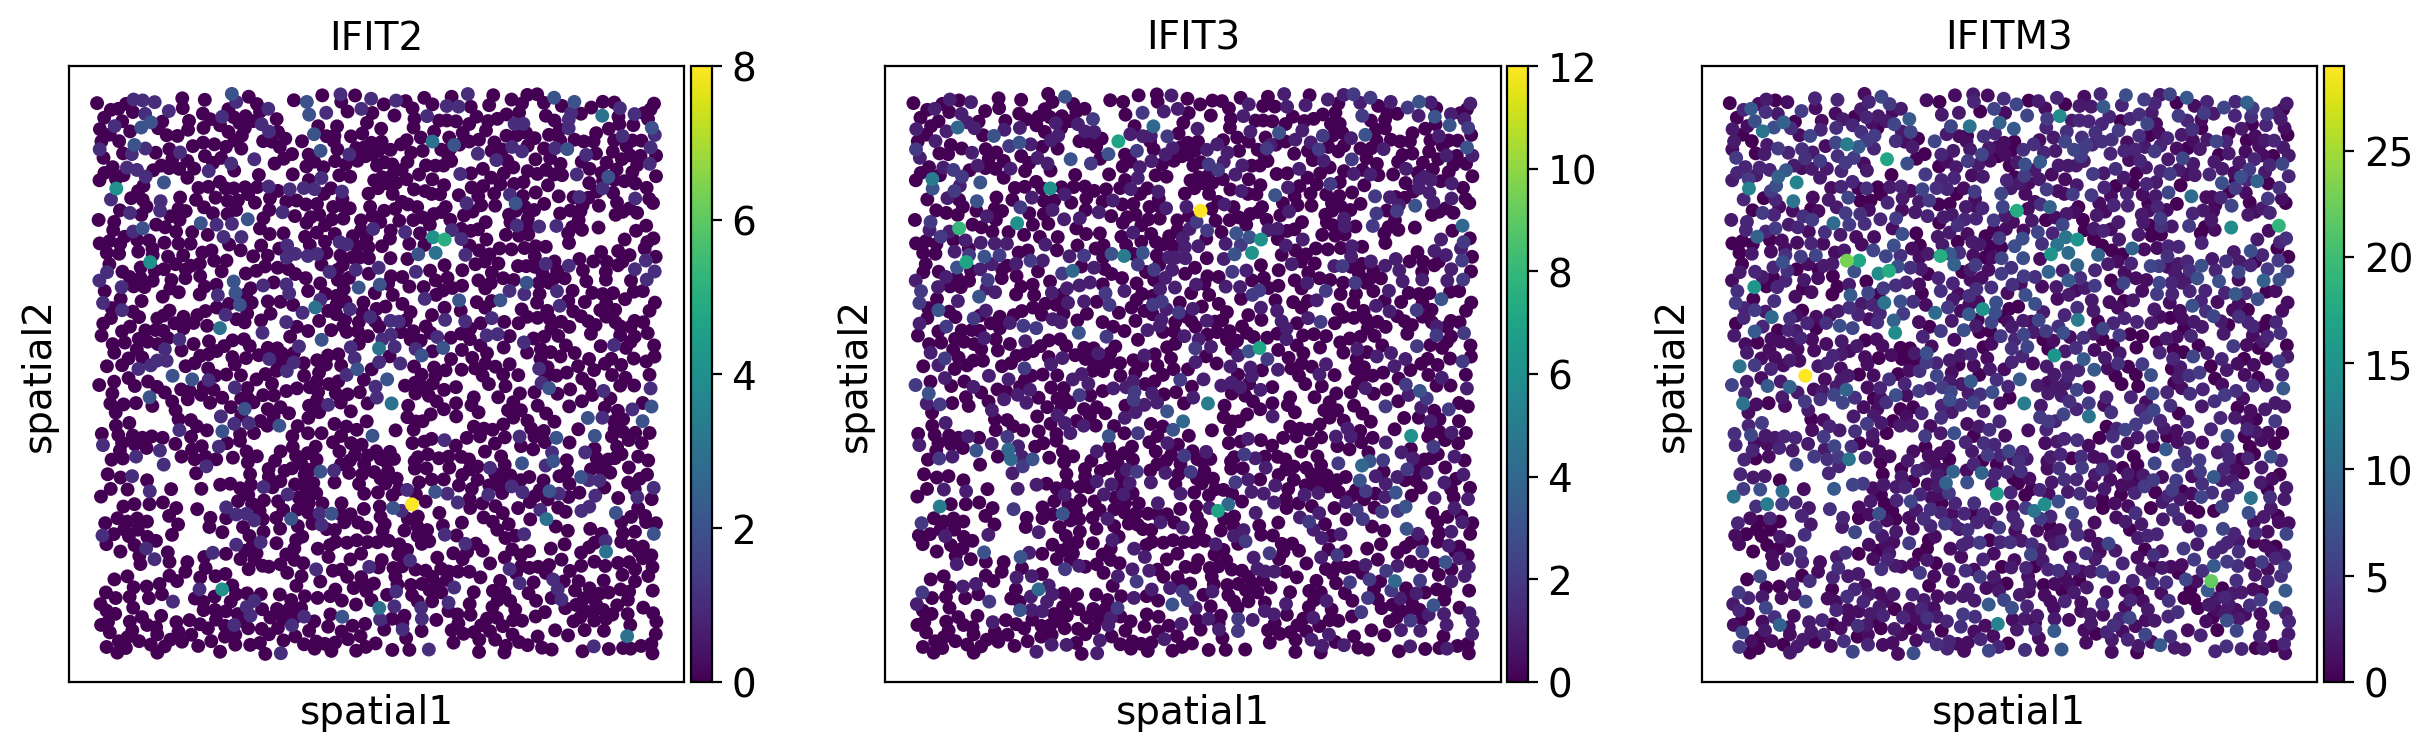

In [21]:
# find the genes
# avis_sub = avis[:, avis.var['highly_variable']].copy()
avis_sub = avis3.copy()
sc.pl.embedding(avis_sub, basis='spatial', color=['IFIT2','IFIT3','IFITM3'], use_raw=False, s=1e2)

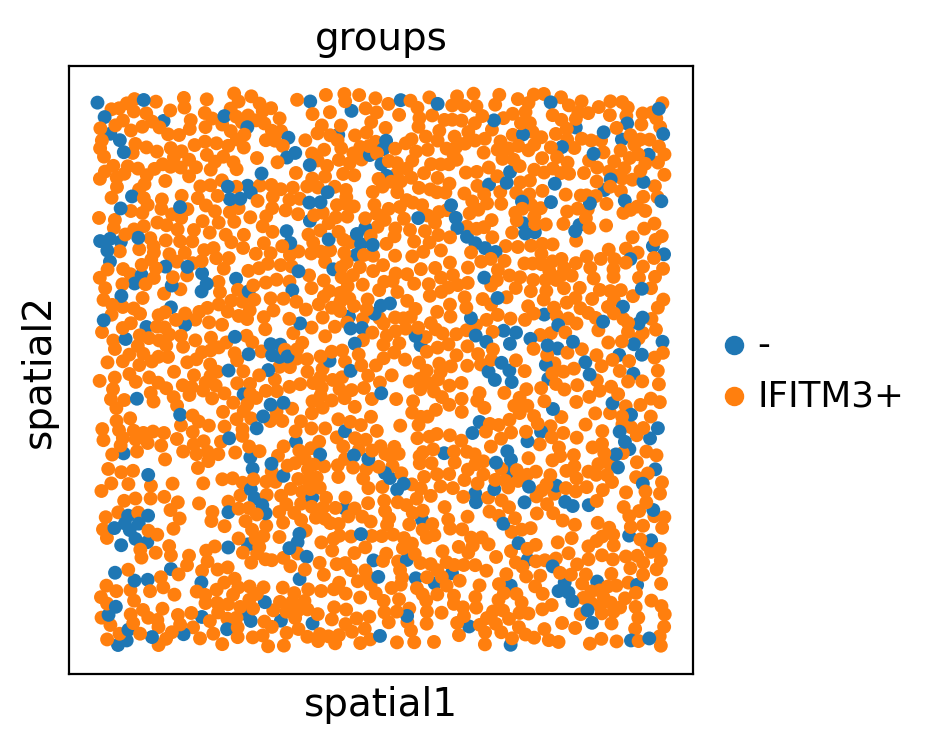

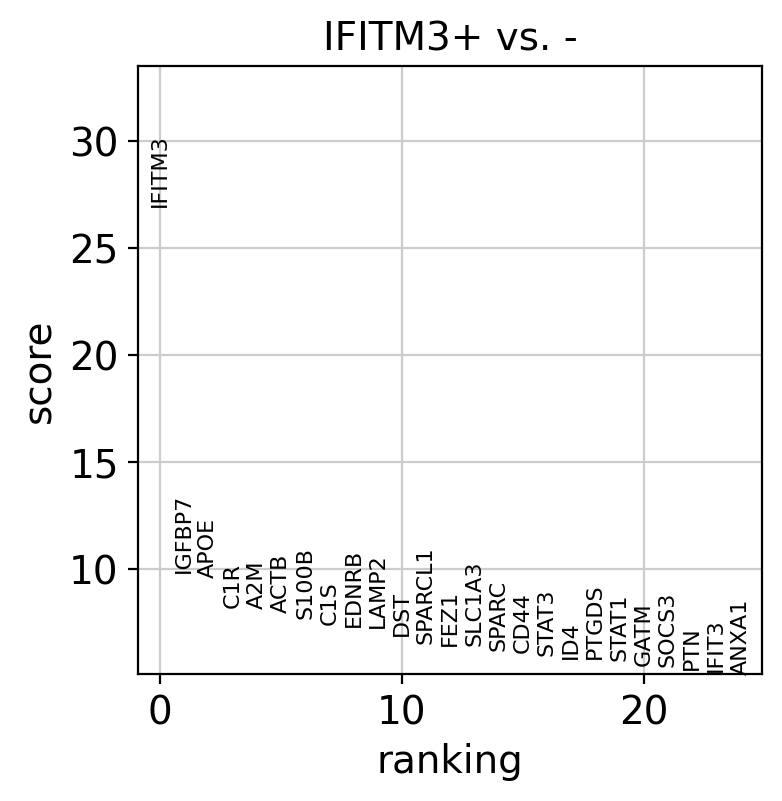

In [22]:
# define the genes that distinguish ISG15 spots currently
avis_sub.obs['groups'] = (sc.get.obs_df(avis_sub, keys=['IFITM3']).max(1) > 0).map({True:'IFITM3+', False:'-'})
sc.pl.embedding(avis_sub, basis='spatial', color=['groups'], use_raw=False, s=1e2)
# calculate differential expression
sc.tl.rank_genes_groups(avis_sub, method='wilcoxon', use_raw=False, groupby='groups', group=['IFITM3+'], reference='-')
sc.pl.rank_genes_groups(avis_sub, n_genes=25, sharey=False)

In [23]:
# derive the signature
'\''+'\',\''.join(pd.DataFrame(avis_sub.uns['rank_genes_groups']['names']).iloc[:25, 0].tolist())+'\''

"'IFITM3','IGFBP7','APOE','C1R','A2M','ACTB','S100B','C1S','EDNRB','LAMP2','DST','SPARCL1','FEZ1','SLC1A3','SPARC','CD44','STAT3','ID4','PTGDS','STAT1','GATM','SOCS3','PTN','IFIT3','ANXA1'"

In [24]:
from scipy.spatial.distance import pdist, squareform

/tmp/ipykernel_3454793/1489802821.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 30)[1]] = 'perturbed-neighbors1'
/tmp/ipykernel_3454793/148

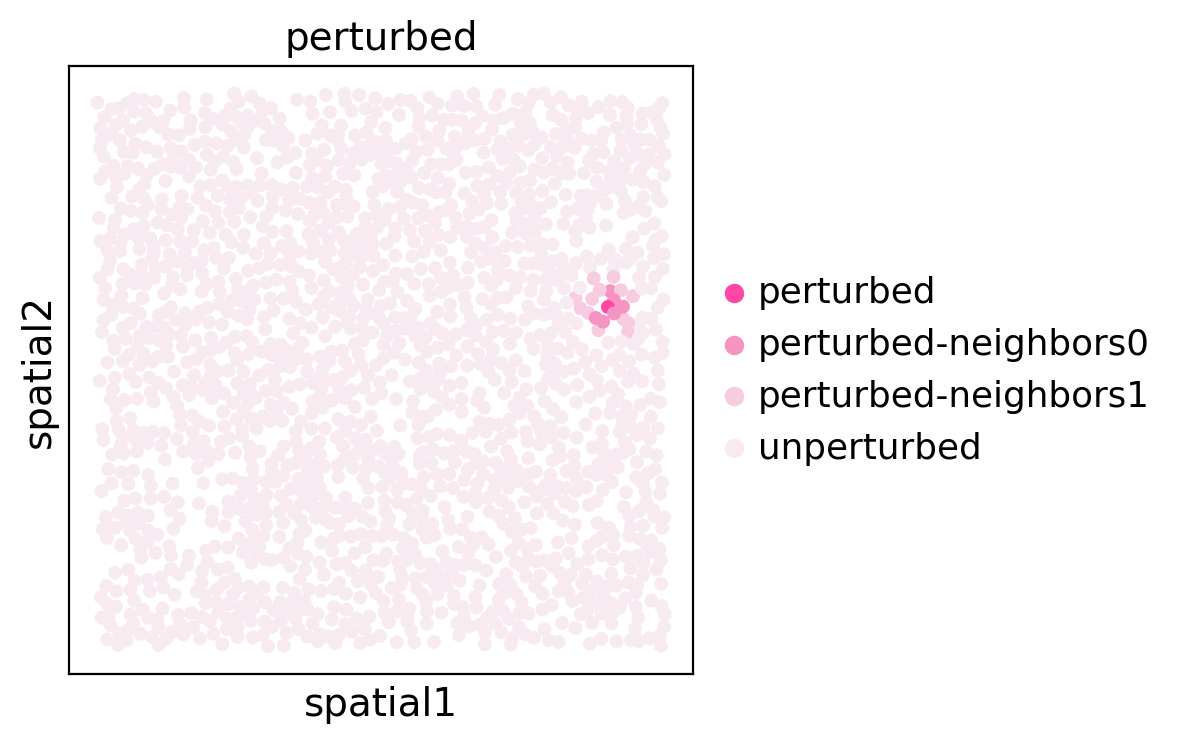

In [25]:
# propose an X introducing ISG15 inflammation
proposed_x = avis_sub.X.toarray().copy()
# adjust the X so we artificially introduce signaling to the center left side of the tissue
np.random.seed(0)
df_gex = sc.get.obs_df(avis_sub, keys=['IFITM3'])['IFITM3']
mask = avis_sub.obs.index == np.random.choice(avis_sub.obs.index[df_gex > 0], size=1)[0]
idx = np.where(avis_sub.var_names == 'IFITM3')[0][0]
proposed_x[mask, idx] = 0
avis_sub.obs['perturbed'] = 'unperturbed'
avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 30)[1]] = 'perturbed-neighbors1'
avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 15)[1]] = 'perturbed-neighbors0'
avis_sub.obs.loc[mask, 'perturbed'] = 'perturbed'
avis_sub.uns['perturbed_colors'] = ['#ff47a6','#f593c2','#f7cbe0','#f7ebf1']
sc.pl.embedding(avis_sub, basis='spatial', color=['perturbed'], use_raw=False, s=1e2)

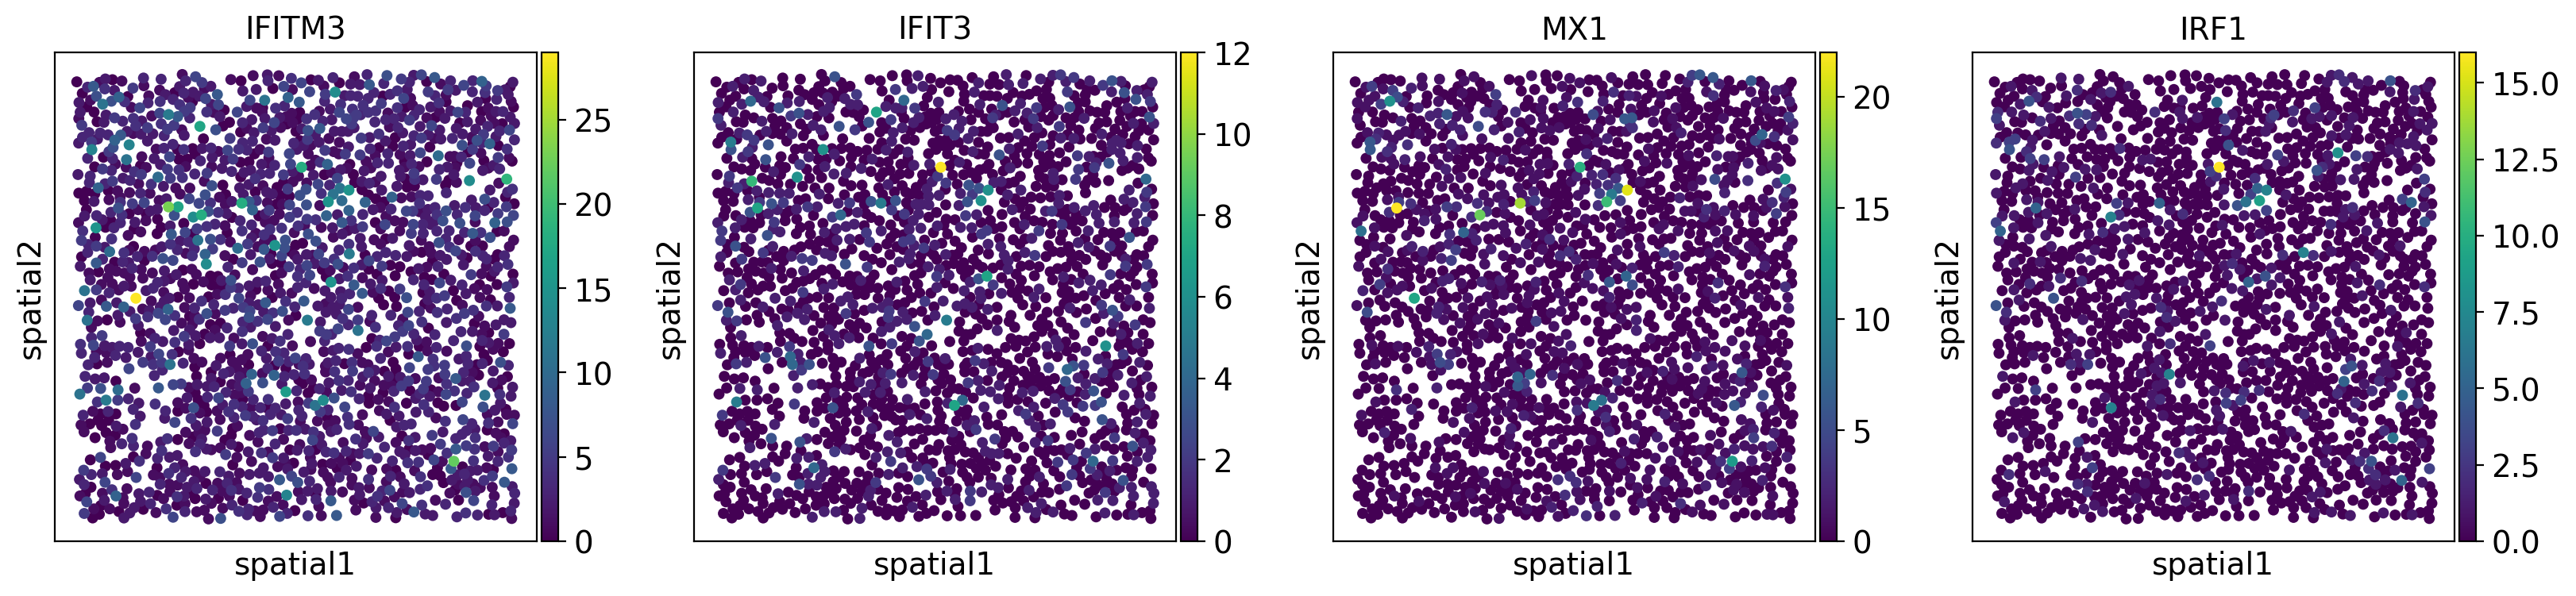

In [26]:
# demonstrate what the proposed x looks like pre scaling
import scipy.sparse
avis_sub.X = scipy.sparse.csr_matrix(proposed_x)
sc.pl.embedding(avis_sub, basis='spatial', color=['IFITM3','IFIT3','MX1','IRF1'], use_raw=False, s=1e2)

In [27]:
# avis_sub.write_h5ad(
#     'data/xenium_human_gbm/avis_perturbed.h5',
# )


In [28]:
# #save perturbed anndata
# h5ad_path_perturbed='data/xenium_human_gbm/avis_perturbed.h5'

# loader = get_dataset_loaders(h5ad_path_perturbed, "sangerID", 6, True, )

In [29]:
from celcomen.training_plan.train import train_simcomen


## IN simcomen I NEED TO ADD A VARIABLE "DEVICE_FOR_HELPERS", AND THEN ADD THIS VARIABLE IN THE HELPERS FUNCTIONS!!! TO SOLVE THE ERROR BELOW

In [34]:
n_genes= len(genes) #33
n_neighbors=6
seed=1
zmft_scalar = 0.1
epochs = 300
learning_rate = 5e-3

# covert gex to torch tensor
x = torch.from_numpy(proposed_x).to("cuda")
# define the model
model_gen = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)

# artifically set the g2g matrix
model_gen.set_g2g( model.conv1.lin.weight.clone().detach().to("cuda") )
model_gen.set_g2g_intra( model.lin.weight.clone().detach().to("cuda") )
# initialize a gene expression matrix
input_sphex = calc_sphex(x).clone().detach().numpy()
model_gen.set_sphex( torch.from_numpy(input_sphex.astype('float32')).to("cuda") )

model_gen.to("cuda")
losses = train_simcomen(epochs, learning_rate, model_gen, edge_index.to("cuda"), zmft_scalar=zmft_scalar, seed=1, device="cuda")

# # set up the optimizer
# optimizer = torch.optim.SGD(model_gen.parameters(), lr=learning_rate, momentum=0)
# # keep track of the losses per data object
# loss, losses = None, []
# # train the model
# model_gen.train()
# tmp_gexs = []
# # work through epochs
# for epoch in tqdm(range(epochs), total=epochs):
#     # derive the message as well as the mean field approximation
#     msg, msg_intra, log_z_mft = model_gen(edge_index, 1)
#     if (epoch % 5) == 0:
#         tmp_gex = model_gen.gex.clone().detach().numpy()
#         tmp_gexs.append(tmp_gex)
#     # compute the loss and track it
#     loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model_gen.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model_gen.gex))) )
#     losses.append(loss.detach().numpy()[0][0])
#     print(f"Loss={losses[-1]}")
#     # derive the gradients, update, and clear
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()

  0%|                                                                                                                         | 0/300 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
# create the plot
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')

In [31]:
# define the parameters of the model
n_genes = avis_sub.shape[1]
learning_rate = 1e-3
zmft_scalar = 1e-1
seed = 0
epochs = 50

In [32]:
# instantiate the model, input and output will be the same
model = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
# now perform the simulation
np.random.seed(seed)
# convert the gene expression data to numpy
x = torch.from_numpy(proposed_x)
# sphere normalize the data (just in case)
norm_factor = torch.sqrt(torch.pow(x, 2).sum(1)).reshape(-1,1)
assert (norm_factor > 0).all()
x = torch.div(x, norm_factor)
# artifically set the g2g matrix
model.set_g2g(model_rev.conv1.lin.weight.clone().detach())
model.set_g2g_intra(model_rev.lin.weight.clone().detach())
# initialize a gene expression matrix
input_sphex = calc_sphex(x).clone().detach().numpy()
model.set_sphex(torch.from_numpy(input_sphex.astype('float32')))

In [33]:
# set up the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
# keep track of the losses per data object
loss, losses = None, []
# train the model
model.train()
tmp_gexs = []
# work through epochs
for epoch in tqdm(range(epochs), total=epochs):
    # derive the message as well as the mean field approximation
    msg, msg_intra, log_z_mft = model(edge_index, 1)
    if (epoch % 5) == 0:
        tmp_gex = model.gex.clone().detach().numpy()
        tmp_gexs.append(tmp_gex)
    # compute the loss and track it
    loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
    losses.append(loss.detach().numpy()[0][0])
    print(f"Loss={losses[-1]}")
    # derive the gradients, update, and clear
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|                                                                                                                                                                      | 0/50 [00:00<?, ?it/s]

Loss=138286.71875


  2%|███                                                                                                                                                        | 1/50 [02:48<2:17:42, 168.63s/it]

Loss=314968.71875


  4%|██████▏                                                                                                                                                    | 2/50 [05:50<2:21:19, 176.66s/it]

Loss=111975.390625


  6%|█████████▎                                                                                                                                                 | 3/50 [09:11<2:26:55, 187.56s/it]

Loss=159604.40625


  8%|████████████▍                                                                                                                                              | 4/50 [12:04<2:19:18, 181.70s/it]

Loss=52552.26953125


 10%|███████████████▌                                                                                                                                           | 5/50 [15:18<2:19:40, 186.24s/it]

Loss=116658.0625


 12%|██████████████████▌                                                                                                                                        | 6/50 [18:23<2:16:21, 185.95s/it]

Loss=20137.685546875


 14%|█████████████████████▋                                                                                                                                     | 7/50 [22:07<2:22:02, 198.20s/it]

Loss=76093.4765625


 16%|████████████████████████▊                                                                                                                                  | 8/50 [25:06<2:14:27, 192.08s/it]

Loss=14310.1669921875


 18%|███████████████████████████▉                                                                                                                               | 9/50 [28:02<2:07:57, 187.27s/it]

Loss=45996.51171875


 20%|██████████████████████████████▊                                                                                                                           | 10/50 [31:17<2:06:23, 189.58s/it]

Loss=15133.912109375


 22%|█████████████████████████████████▉                                                                                                                        | 11/50 [34:16<2:01:01, 186.20s/it]

Loss=28881.341796875


 24%|████████████████████████████████████▉                                                                                                                     | 12/50 [37:44<2:02:10, 192.90s/it]

Loss=14151.453125


 26%|████████████████████████████████████████                                                                                                                  | 13/50 [40:44<1:56:39, 189.16s/it]

Loss=19057.34375


 28%|███████████████████████████████████████████                                                                                                               | 14/50 [43:43<1:51:32, 185.91s/it]

Loss=12627.732421875


 30%|██████████████████████████████████████████████▏                                                                                                           | 15/50 [46:54<1:49:19, 187.43s/it]

Loss=13509.806640625


 32%|█████████████████████████████████████████████████▎                                                                                                        | 16/50 [50:05<1:46:49, 188.52s/it]

Loss=10813.1005859375


 34%|████████████████████████████████████████████████████▎                                                                                                     | 17/50 [53:07<1:42:36, 186.57s/it]

Loss=10369.5146484375


 36%|███████████████████████████████████████████████████████▍                                                                                                  | 18/50 [56:25<1:41:19, 189.98s/it]

Loss=9071.0791015625


 38%|██████████████████████████████████████████████████████████▌                                                                                               | 19/50 [59:19<1:35:44, 185.30s/it]

Loss=8462.0546875


 40%|████████████████████████████████████████████████████████████▊                                                                                           | 20/50 [1:02:42<1:35:18, 190.61s/it]

Loss=7647.712890625


 42%|███████████████████████████████████████████████████████████████▊                                                                                        | 21/50 [1:05:39<1:30:02, 186.31s/it]

Loss=7156.916015625


 44%|██████████████████████████████████████████████████████████████████▉                                                                                     | 22/50 [1:08:41<1:26:27, 185.26s/it]

Loss=6565.607421875


 46%|█████████████████████████████████████████████████████████████████████▉                                                                                  | 23/50 [1:11:41<1:22:40, 183.71s/it]

Loss=6191.32177734375


 48%|████████████████████████████████████████████████████████████████████████▉                                                                               | 24/50 [1:14:48<1:20:01, 184.67s/it]

Loss=5745.015625


 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 25/50 [1:17:47<1:16:08, 182.74s/it]

Loss=5453.890625


 52%|███████████████████████████████████████████████████████████████████████████████                                                                         | 26/50 [1:20:41<1:12:05, 180.22s/it]

Loss=5111.357421875


 54%|██████████████████████████████████████████████████████████████████████████████████                                                                      | 27/50 [1:23:45<1:09:30, 181.32s/it]

Loss=4880.38671875


 56%|█████████████████████████████████████████████████████████████████████████████████████                                                                   | 28/50 [1:26:50<1:06:55, 182.50s/it]

Loss=4613.86669921875


 58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 29/50 [1:30:30<1:07:49, 193.80s/it]

Loss=4427.92578125


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 30/50 [1:33:49<1:05:07, 195.35s/it]

Loss=4218.17138671875


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 31/50 [1:36:55<1:00:56, 192.45s/it]

Loss=4066.86962890625


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 32/50 [1:40:07<57:41, 192.28s/it]

Loss=3900.281982421875


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 33/50 [1:43:17<54:15, 191.53s/it]

Loss=3776.247802734375


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 34/50 [1:46:20<50:23, 188.99s/it]

Loss=3643.041259765625


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 35/50 [1:49:15<46:13, 184.89s/it]

Loss=3540.891357421875


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 36/50 [1:52:50<45:14, 193.88s/it]

Loss=3433.906494140625


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 37/50 [1:56:27<43:30, 200.84s/it]

Loss=3349.640625


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 38/50 [2:00:07<41:18, 206.57s/it]

Loss=3263.56005859375


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 39/50 [2:03:05<36:18, 198.00s/it]

Loss=3194.1484375


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 40/50 [2:05:54<31:32, 189.22s/it]

Loss=3124.966064453125


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 41/50 [2:09:11<28:46, 191.79s/it]

Loss=3068.07080078125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 42/50 [2:11:36<23:42, 177.79s/it]

Loss=3012.71875


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 43/50 [2:14:24<20:24, 174.87s/it]

Loss=2966.4853515625


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 44/50 [2:17:19<17:28, 174.70s/it]

Loss=2922.551025390625


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 45/50 [2:20:19<14:41, 176.35s/it]

Loss=2885.442138671875


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 46/50 [2:23:23<11:54, 178.74s/it]

Loss=2850.962890625


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 47/50 [2:26:25<08:59, 179.67s/it]

Loss=2821.620361328125


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 48/50 [2:29:36<06:06, 183.07s/it]

Loss=2794.903076171875


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 49/50 [2:31:55<02:49, 169.75s/it]

Loss=2772.04833984375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [2:34:52<00:00, 185.85s/it]


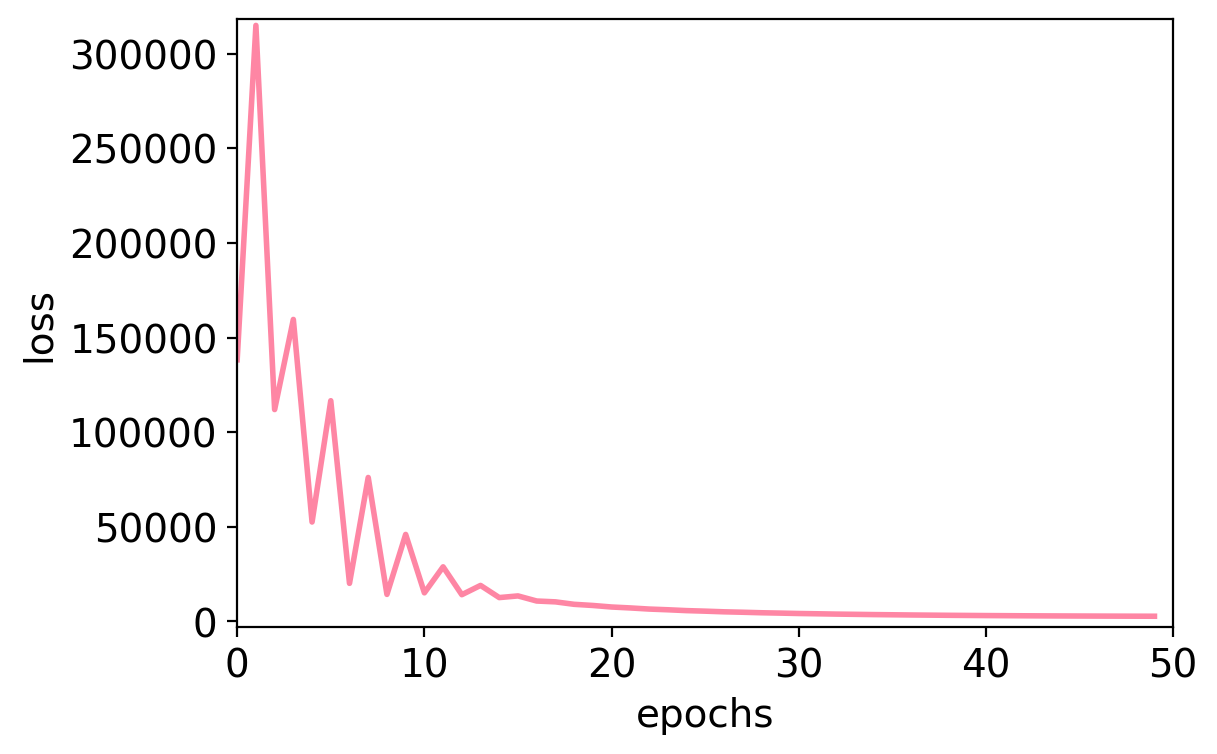

In [34]:
# plot the loss
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')
# retrieve the data
output_gex = model.gex.detach().numpy()
output_msg = msg.detach().numpy()

In [35]:
# find the genes of interest
genes = ['IFITM3','IFIT3','MX1','IRF1']
genes = [x for x in genes if x in avis_sub.var_names.tolist()]

In [36]:
# add the layers
for idx, tmp_gex in enumerate(tmp_gexs):
    avis_sub.layers[f'input{idx}'] = tmp_gex
avis_sub.layers['output'] = output_gex

In [37]:
avis_sub

AnnData object with n_obs × n_vars = 1781 × 480
    obs: 'n_counts', 'groups', 'perturbed'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'groups_colors', 'rank_genes_groups', 'perturbed_colors'
    obsm: 'spatial'
    layers: 'input0', 'input1', 'output', 'input2', 'input3', 'input4', 'input5', 'input6', 'input7', 'input8', 'input9'

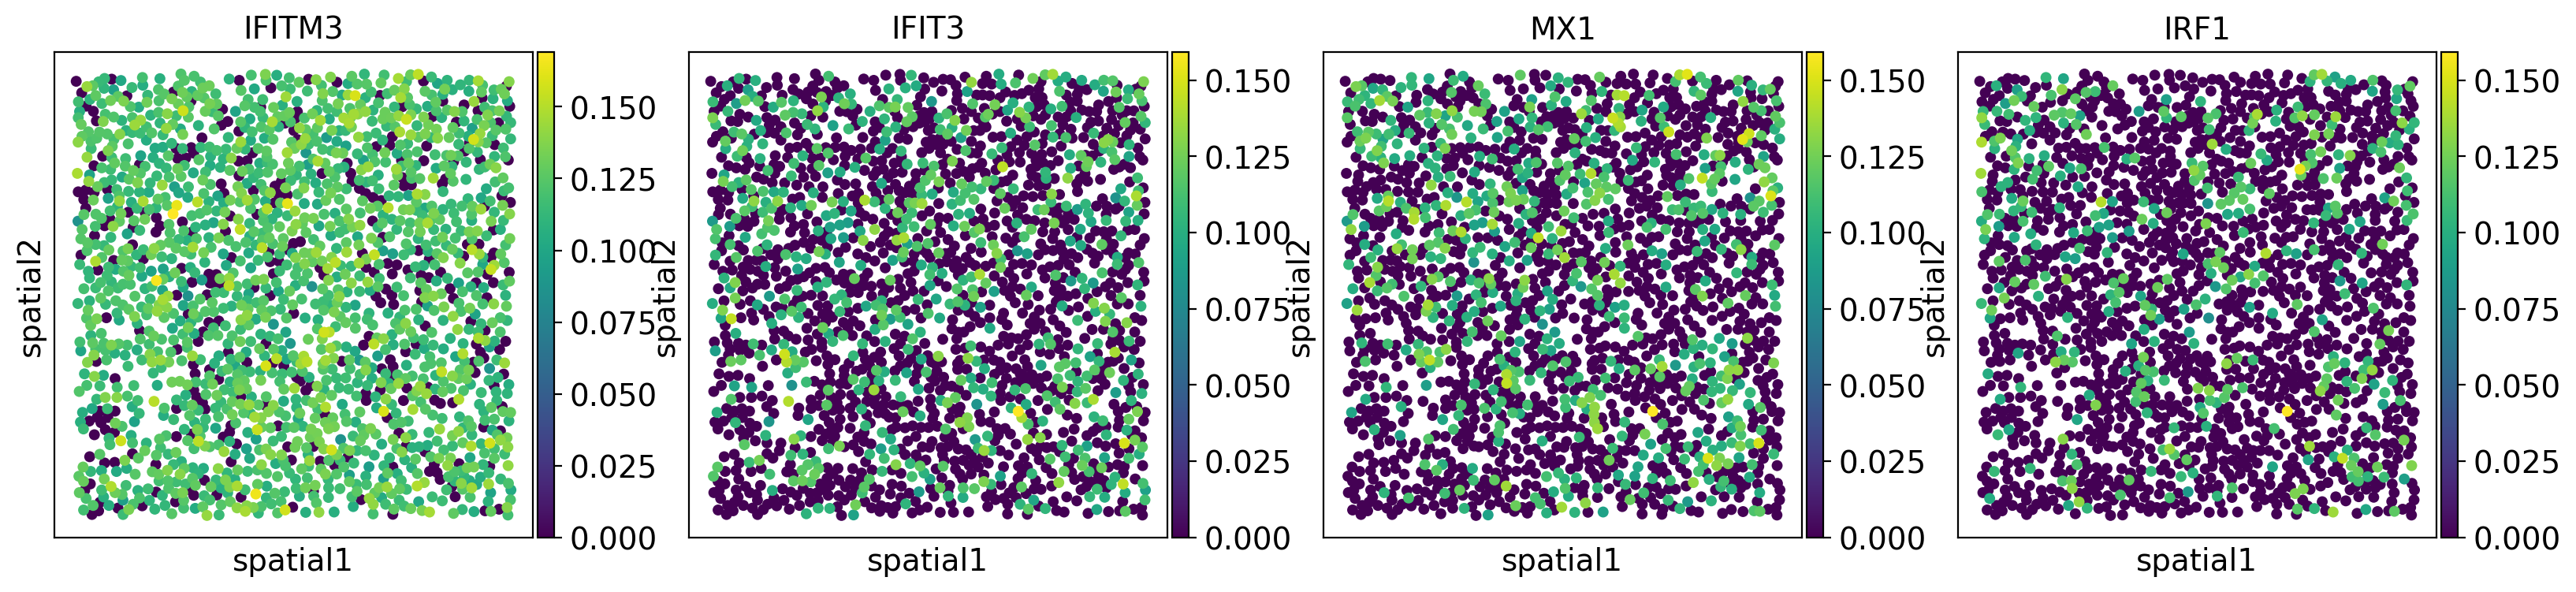

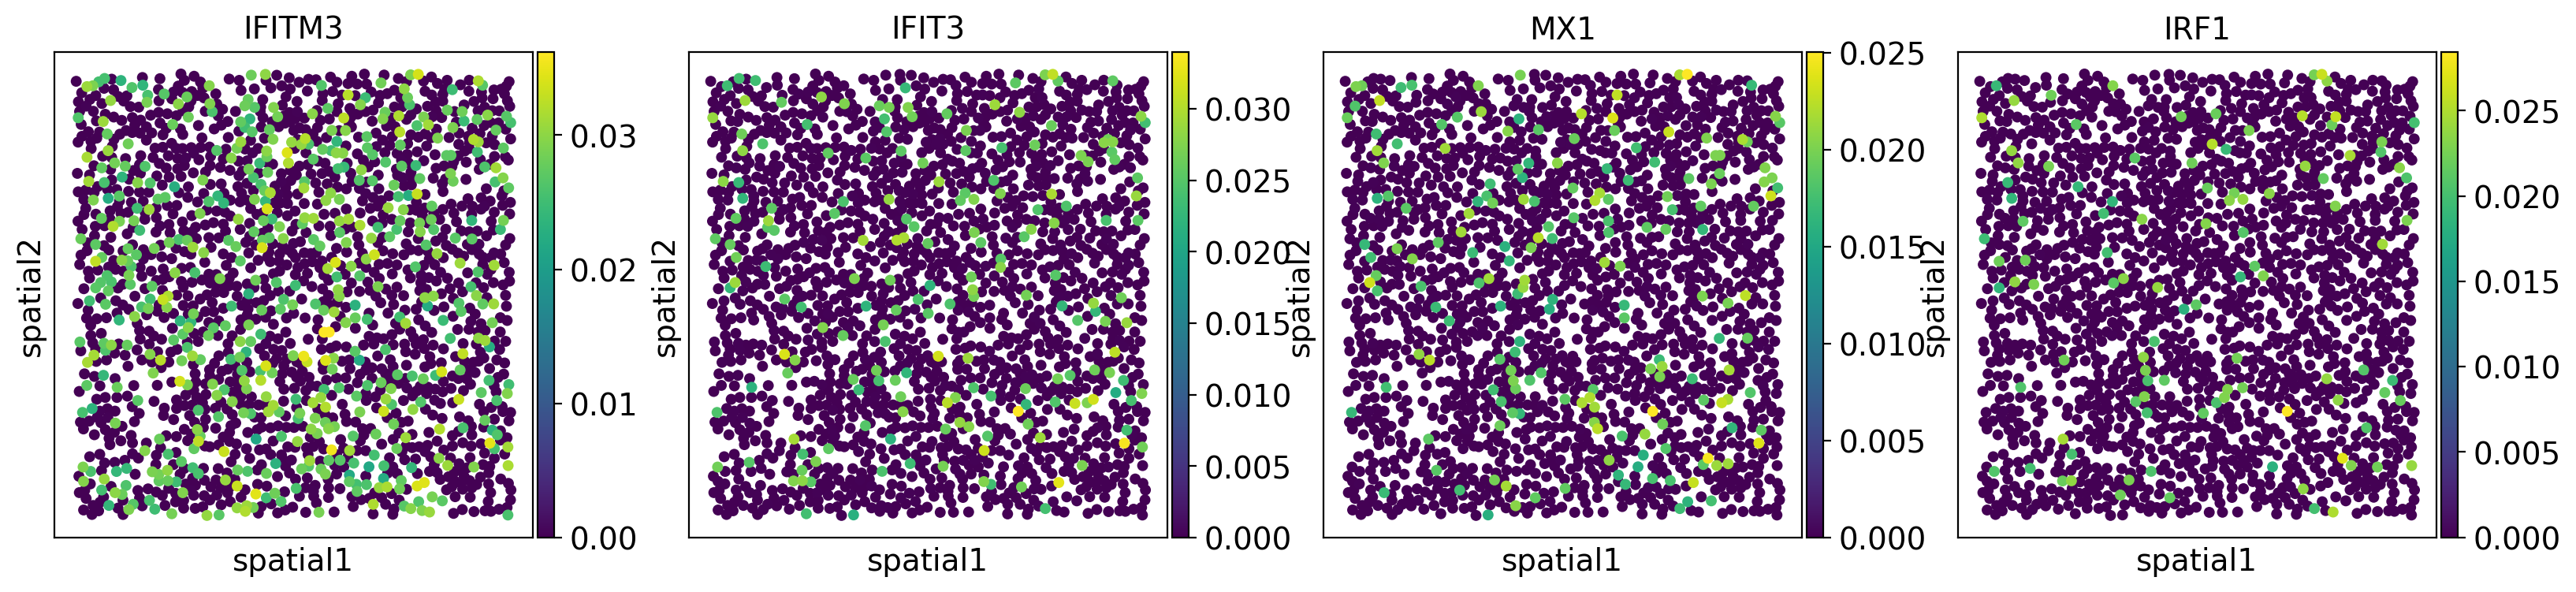

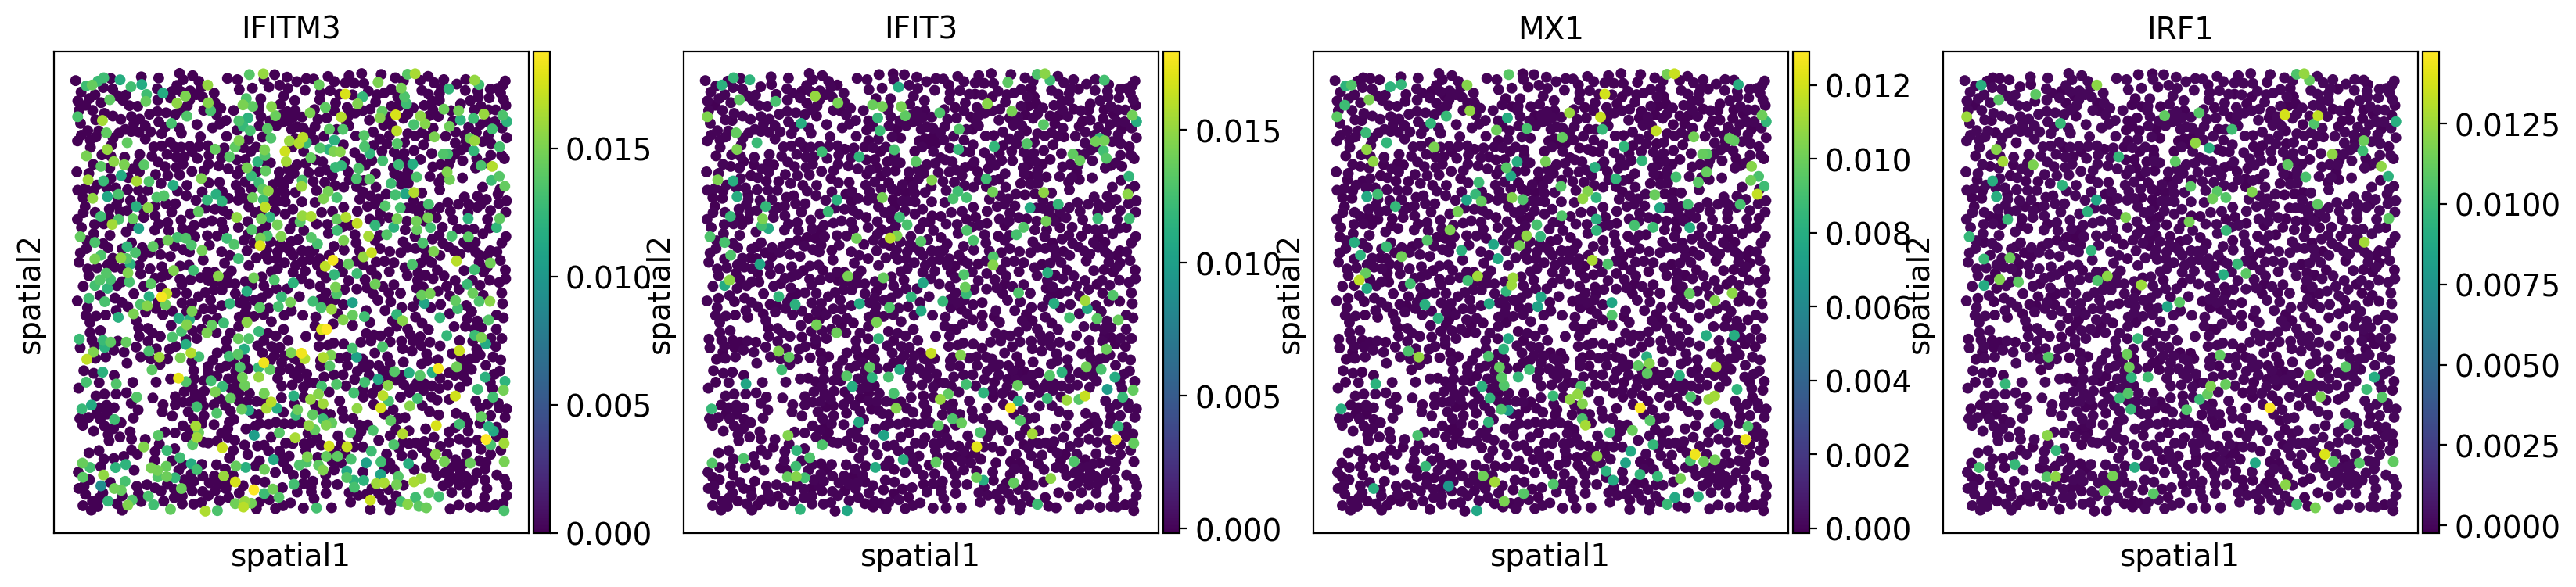

In [38]:
# plot the genes of interest
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='input0')
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='input3')
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='output')

In [ ]:
# compute the differential within the area of interest vs outside
avis_sub.layers['diff'] = avis_sub.layers['output'] - avis_sub.layers['input0']
mask0 = avis_sub.obs['perturbed'] == 'unperturbed'
mask1 = avis_sub.obs['perturbed'] == 'perturbed'
diff_in_vs_out_p = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
# now compute differential for neighbors
mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors0'
diff_in_vs_out_pn0 = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors1'
diff_in_vs_out_pn1 = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
# remove the perturbed genes to get a clean look
perturbed_genes = ['IFITM3']
perturbed_label = 'ifitm3'
diff_in_vs_out_p = diff_in_vs_out_p.loc[~diff_in_vs_out_p.index.isin(perturbed_genes)]
diff_in_vs_out_pn0 = diff_in_vs_out_pn0.loc[~diff_in_vs_out_pn0.index.isin(perturbed_genes)]
diff_in_vs_out_pn1 = diff_in_vs_out_pn1.loc[~diff_in_vs_out_pn1.index.isin(perturbed_genes)]
# write these matrices out
diff_in_vs_out_p.to_csv(f'20240618.learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_p.csv')
diff_in_vs_out_pn0.to_csv(f'20240618.learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_pn0.csv')
diff_in_vs_out_pn1.to_csv(f'20240618.learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_pn1.csv')

In [ ]:
# do not include isg15 itself
genes_ = pd.DataFrame(avis_sub.uns['rank_genes_groups']['names']).iloc[:25, 0].tolist()[1:]

In [ ]:
# retrieve the results
df_expr = pd.DataFrame(columns=['p','pn0','pn1','u'])
for layer in ['input1','input2','input3','input4','input5','input6','input7','input8','input9','output']:
    # compute the expression
    mask1 = avis_sub.obs['perturbed'] == 'perturbed'
    expr_p = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors0'
    expr_pn0 = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors1'
    expr_pn1 = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'unperturbed'
    expr_u = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    df_expr.loc[layer] = expr_p, expr_pn0, expr_pn1, expr_u

In [ ]:
# derive the scores
fig, ax = plt.subplots(figsize=[2.9, 5.6])
ax = sns.heatmap(df_expr, cmap='viridis')
ax.grid(False)

In [ ]:
# derive the scores
df_expr -= np.mean(df_expr.values.flatten())
df_expr /= np.std(df_expr.values.flatten())
fig, ax = plt.subplots(figsize=[2.9, 5.6])
ax = sns.heatmap(df_expr, cmap='viridis')
ax.grid(False)

In [ ]:
# derive the scores
for col, color in zip(['p','pn0','pn1','u'], ['#ff47a6','#f593c2','#f7cbe0','#f7ebf1']):
    fig, ax = plt.subplots(figsize=[4, 4])
    ax.scatter(df_expr.index, df_expr[col], color='k', s=9e1, zorder=1)
    ax.scatter(df_expr.index, df_expr[col], color=color, s=5e1, zorder=2)
    ax.plot(df_expr.index, df_expr[col], color='k', lw=3.5, zorder=0)
    ax.plot(df_expr.index, df_expr[col], color=color, lw=1, zorder=2)
    ax.grid(False)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set(xlabel='timepoint', ylabel='IFITM3 score', title=col)